In [30]:
#Imports iniciais
import gradio as gr
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import base64
import os
import glob
import numpy as np
import gradio as gr
import json
import re
import time
from markdown_pdf import MarkdownPdf, Section
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import CodeInterpreterTool
from azure.ai.projects.models import FilePurpose
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import FileSearchTool, MessageTextContent

### Custom Vision Configuration

In [ ]:
# Este código define as configurações necessárias para se conectar ao modelo de detecção de objetos do Azure Custom Vision.
ENDPOINT = [ENDPOINT]
PREDICTION_KEY = [PREDICTION_KEY]
PROJECT_ID = [PROJECT_ID]
PUBLISH_ITERATION_NAME = [PUBLISH_ITERATION_NAME]
CONFIDENCE_THRESHOLD = 0.9

### Azure AI Foundry Model Configuration

In [ ]:
# Este código define as configurações necessárias para se conectar a diferentes endpoints de serviços de IA na Azure.
GPT_4O_ENDPOINT = [GPT_4O_ENDPOINT]
O1_ENDPOINT = [O1_ENDPOINT]
AZURE_AI_FOUNDRY_API_KEY  = [AZURE_AI_FOUNDRY_API_KEY]

### Detecção de Objetos

In [33]:
## Esta célula define a função `detect_objects`, que realiza a detecção de objetos em uma imagem usando o Azure Custom Vision.
def detect_objects(image_path):
    # Esta célula define a URL de previsão do modelo de detecção de objetos.
    # A URL é construída usando o endpoint, o ID do projeto e o nome da iteração publicada.
    prediction_url = f"{ENDPOINT}/customvision/v3.0/Prediction/{PROJECT_ID}/detect/iterations/{PUBLISH_ITERATION_NAME}/image"
    
    headers = {
        "Prediction-Key": PREDICTION_KEY,
        "Content-Type": "application/octet-stream"
    }
    
    # Verifica se o arquivo de imagem existe antes de tentar abri-lo.
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()
    
    # Envia a imagem para o modelo de detecção de objetos e obtém a resposta.
    try:
        response = requests.post(prediction_url, headers=headers, data=image_data)
        response.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        print(f"Response content: {response.content}")
        if response.status_code == 401:
            print("Access denied. Please check your prediction key and endpoint.")
        return None
    except Exception as err:
        print(f"Other error occurred: {err}")
        return None
    
    # Processa a resposta JSON e extrai as previsões.
    predictions = response.json()
    return predictions

### Generate Bounding Boxes

In [34]:
## Esta celula define a função `generate_bounding_boxes`, que gera uma imagem com caixas delimitadoras para os objetos detectados na imagem original.
def generate_bounding_boxes(image_path, predictions, confidence_threshold, output_bb_image="bounding_boxes.png"):
    # Abre a imagem original a partir do caminho fornecido
    image = Image.open(image_path)
    # Cria uma figura e um eixo para exibir a imagem
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Itera sobre todas as previsões fornecidas
    for prediction in predictions:
        # Filtra apenas as previsões com probabilidade acima do limiar definido
        if prediction['probability'] > confidence_threshold:
            tag_name = prediction['tagName'].lower()
            bbox     = prediction['boundingBox']

            # Calcula as coordenadas da caixa delimitadora
            left   = bbox['left']   * image.width
            top    = bbox['top']    * image.height
            width  = bbox['width']  * image.width
            height = bbox['height'] * image.height

            # Desenha a caixa delimitadora na imagem
            # Define uma cor aleatória para a caixa delimitadora
            color = (random.random(), random.random(), random.random())
            rect  = patches.Rectangle(
                (left, top), width, height,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            # Adiciona o nome da classe e a probabilidade acima da caixa delimitadora
            ax.text(
                left, top - 10,
                f"{prediction['tagName']} ({prediction['probability']*100:.2f}%)",
                color=color, fontsize=12, weight='bold'
            )
    # Ajusta os limites do eixo para evitar cortes nas caixas delimitadoras
    plt.axis('off')
    fig.savefig(output_bb_image, bbox_inches='tight')
    plt.close(fig)
    
    # Retorna o caminho da imagem com as caixas delimitadoras desenhadas
    return  output_bb_image

{'id': '1e75454c-1e5c-4b95-ae5a-ebbc1def071e', 'project': '6fcbbcf0-5c76-4e21-95c9-7d838ae2cbf8', 'iteration': 'e15e4f39-7f87-4303-9a88-c3e08e5f6427', 'created': '2025-05-19T01:47:18.119Z', 'predictions': [{'probability': 0.9995598, 'tagId': 'ca6977a3-784d-41ad-9fe9-1c865aa54589', 'tagName': 'Cadeirante', 'boundingBox': {'left': 0.561858, 'top': 0.6838902, 'width': 0.053393543, 'height': 0.05261135}}, {'probability': 0.9990426, 'tagId': 'ca6977a3-784d-41ad-9fe9-1c865aa54589', 'tagName': 'Cadeirante', 'boundingBox': {'left': 0.50126827, 'top': 0.67555827, 'width': 0.057612896, 'height': 0.056985855}}, {'probability': 0.99520457, 'tagId': 'ca6977a3-784d-41ad-9fe9-1c865aa54589', 'tagName': 'Cadeirante', 'boundingBox': {'left': 0.7514901, 'top': 0.69540733, 'width': 0.07057363, 'height': 0.06939697}}, {'probability': 0.99276215, 'tagId': 'ca6977a3-784d-41ad-9fe9-1c865aa54589', 'tagName': 'Cadeirante', 'boundingBox': {'left': 0.20394278, 'top': 0.6545685, 'width': 0.05733058, 'height': 0.03

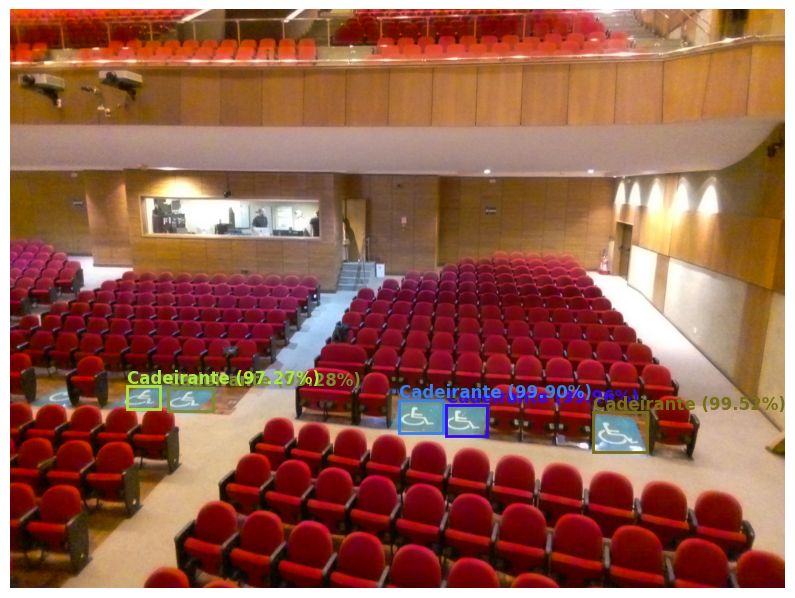

In [35]:
from IPython.display import Image as IPImage, display

# Path para a imagem de teste
image_path = "Auditorio Rui Barbosa New\\Testing images\\20240518110500.JPG"

# Roda a detecção de objetos na imagem
predictions = detect_objects(image_path)
print(predictions)

# Checa se as previsões foram feitas com sucesso e se o campo "predictions" está presente na resposta
if predictions and "predictions" in predictions:
    # Gera  e salva a imagem com as caixas delimitadoras
    output_image_path = generate_bounding_boxes(image_path, predictions["predictions"], CONFIDENCE_THRESHOLD)
    print(f"Bounding boxes generated and saved to: {output_image_path}")
    
    # Exibe a imagem com as caixas delimitadoras
    display(IPImage(output_image_path))
else:
    print("No predictions were made or an error occurred.")

In [36]:
# Filtra as previsões para incluir apenas aquelas com probabilidade acima do limiar definido
filtered_predictions = [
    {"tagName": pred["tagName"], "probability": pred["probability"]}
    for pred in predictions["predictions"]
    if pred["probability"] > CONFIDENCE_THRESHOLD
]

# Cria um objeto JSON com as previsões filtradas
filtered_predictions_json = json.dumps(filtered_predictions, indent=4)

# Salva o JSON em um arquivo

print(filtered_predictions_json)

[
    {
        "tagName": "Cadeirante",
        "probability": 0.9995598
    },
    {
        "tagName": "Cadeirante",
        "probability": 0.9990426
    },
    {
        "tagName": "Cadeirante",
        "probability": 0.99520457
    },
    {
        "tagName": "Cadeirante",
        "probability": 0.99276215
    },
    {
        "tagName": "Cadeirante",
        "probability": 0.9726605
    }
]


### Call the model

In [37]:
def call_model(model, bounding_boxes_filespath):

    # Controir o caminho do arquivo de texto com as instruções
    with open("instructions.txt", "r") as file:
        instructions_text = file.read()

    # Prepara o conteúdo do usuário para a requisição
    user_content = [
        {
            "type": "text",
            "text": instructions_text
        }
    ]

    # Se disponível, adiciona as previsões filtradas ao conteúdo do usuário
    if os.path.exists(bounding_boxes_filespath) and os.path.isdir(bounding_boxes_filespath):
        image_files = glob.glob(os.path.join(bounding_boxes_filespath, "*.png"))
        for image_file in image_files:
            with open(image_file, "rb") as img_file:
                b64_string = base64.b64encode(img_file.read()).decode('utf-8')
                user_content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{b64_string}"
                    }
                })


    if model == "gpt-4o":
        # Constroi o corpo da requisição para o modelo gpt-4o
        model_endpoint = GPT_4O_ENDPOINT
        body = {
            "messages": [
                {
                    "role": "system",
                    "content": "You are an image analysis assistant. Follow the user's instructions carefully."
                },
                {
                    "role": "user",
                    "content": user_content
                }
            ],
            "max_tokens": 1000,
            "temperature": 0.7
        }
    elif model == "o1":
        # Constroi o corpo da requisição para o modelo o1
       model_endpoint = O1_ENDPOINT
       body = {
            "messages": [
                {
                    "role": "system",
                    "content": "You are an image analysis assistant. Follow the user's instructions carefully."
                },
                {
                    "role": "user",
                    "content": user_content
                }
            ],
            "max_completion_tokens": 4000,
        }
    else:
        raise ValueError("Invalid model type specified. Use 'gpt-4o' or 'o1'.")

    headers = {
        "Content-Type": "application/json",
        "api-key": AZURE_AI_FOUNDRY_API_KEY
    }

    response = requests.post(model_endpoint, headers=headers, json=body)
    if response.status_code == 200:
        res_json = response.json()
        usage_metrics = res_json['usage']
        for metric, value in usage_metrics.items():
            print(f"{metric}: {value}")
        return res_json["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Request to model failed with status {response.status_code}, response: {response.text}")

### Generate PDF Report

In [38]:
# Esta célula define a função `generate_report`, que gera um relatório em PDF a partir do texto fornecido.
def generate_report(text):
    pdf = MarkdownPdf(toc_level=2)
    pdf.add_section(Section(text))
    pdf.save("report.pdf")

    return "report.pdf"

### Interface do Gradio

#### Comunicação com o Agente de IA

In [39]:
# Esta celula define a comunicação com o cliente do Azure AI Project.
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str="eastus.api.azureml.ms;66033a66-ff51-47a2-bd44-74f8d69b6c7a;AzureAIDemos;gabriellemosbraz-2525"
)

In [40]:
# # Rodar apenas uma vez para criar o cliente do projeto
# file = project_client.agents.upload_file_and_poll(file_path="report.pdf", purpose="assistants")
# print(f"Uploaded file, file ID: {file.id}")

# vector_store = project_client.agents.create_vector_store_and_poll(file_ids=[file.id], name="accessibility_reports")
# print(f"Created vector store, vector store ID: {vector_store.id}")

# # Create file search tool with resources followed by creating agent
# file_search = FileSearchTool(vector_store_ids=[vector_store.id])

# agent = project_client.agents.create_agent(
#     model="gpt-4o",
#     name="accessibility-agent-report",
#     instructions="Hello, you are helpful assistant and can search information from uploaded files",
#     tools=file_search.definitions,
# )

# print(f"Created agent, ID: {agent.id}")

# # Create thread with file resources.
# # If the agent has multiple threads, only this thread can search this file.
# thread = project_client.agents.create_thread(tool_resources=file_search.resources)

In [41]:
# Esta celula define a função `get_agent_message`, que envia uma mensagem para o agente e obtém a resposta.
def get_agent_message(user_message, thread, agent):
    message = project_client.agents.create_message(thread_id=thread.id, role="user", content=user_message)
    # Cria e processa a execução do agente com a mensagem enviada
    run = project_client.agents.create_and_process_run(thread_id=thread.id, agent_id=agent)
    # Aguarda a conclusão da execução
    messages = project_client.agents.list_messages(thread_id=thread.id)
    print(messages)
    # Pega a última mensagem da lista de mensagens
    last_message = messages.data[0]  # A ultima mensagem é a primeira na lista
    print(last_message)
    if last_message.role == "assistant" and isinstance(last_message.content[-1], MessageTextContent):
        return last_message.content[-1].text.value
    else:
        return None

In [42]:
# Esta célula define a função `update_vector_store_file`, que atualiza o arquivo do vetor de armazenamento com um novo arquivo.
# Ela exclui o arquivo antigo e carrega um novo arquivo, atualizando o vetor de armazenamento com o novo arquivo.
# Isso é útil para manter o vetor de armazenamento atualizado com os arquivos mais recentes (novos reports de acessibilidade que foorem gerados).
def update_vector_store_file(project_client, vector_store, file_path):
    vector_store_files = project_client.agents.list_vector_store_files(vector_store_id=vector_store)
    old_file_ids = [file.id for file in vector_store_files.data]
    print(f"Old file ID: {old_file_ids[-1]}")
    deletion_status = project_client.agents.delete_vector_store_file(vector_store_id=vector_store, file_id=old_file_ids[-1])
    print(f"File deleted, deleted file ID: {deletion_status.id}")
    new_file = project_client.agents.upload_file_and_poll(file_path=file_path, purpose="assistants")
    print(f"Uploaded new file, new file ID: {new_file.id}")
    new_vector_store_file = project_client.agents.create_vector_store_file(vector_store_id=vector_store,file_id=new_file.id)
    print(f"Created new vector store file, file ID: {new_vector_store_file}")
    message = f"The vector store '{vector_store}' has been successfully updated with the new file."
    project_client.agents.create_message(thread_id=thread.id, role="assistant", content=message)
    return new_vector_store_file, message

In [43]:
# Esta célula define a função `format_references`, que formata as referências no texto.
def format_references(text):
    pattern = r"【(\d+):(\d+)†([^\】]+)】"
    
    def repl(match):
        page = match.group(1)
        source = match.group(3)
        return f" (Pagina {page})"
    
    return re.sub(pattern, repl, text)

#### Interface do report gerado

In [44]:
# Esta célula define a função `generate_results`, que gera os resultados da detecção de objetos e atualiza o vetor de armazenamento com o novo relatório.
def generate_results(image_paths, model):
    consolidated_outputs = []
    # garante que o diretório "results" exista antes de salvar os arquivos de saída
    os.makedirs("results", exist_ok=True)

    for image_path, _ in image_paths:  # Desenpacota a tupla (image_path, _) para obter apenas image_path
        # Gera o nome do arquivo de saída para a imagem com caixas delimitadoras
        output_image = f"results/bounding_boxes_{image_paths.index((image_path, _))}.png"
        predictions = detect_objects(image_path)
        consolidated_outputs.append(output_image)

        # Checa se as previsões foram feitas com sucesso e se o campo "predictions" está presente na resposta
        if predictions and "predictions" in predictions:
            # Gera e salva a imagem com as caixas delimitadoras
            output_image_path = generate_bounding_boxes(image_path, predictions["predictions"], CONFIDENCE_THRESHOLD, output_image)
            print(f"Bounding boxes generated and saved to: {output_image_path}")
        else:
            print("No predictions were made or an error occurred.")

    # Chanada do modelo com as imagens de saída
    result = call_model(model, "results")
    
    # Gera o relatório em PDF a partir do resultado consolidado
    report_content = "\n\n".join(
        [f"![Image]({image})" for image in consolidated_outputs] + [result]
    )
    
    report = generate_report(report_content)
    # Atualiza o vetor de armazenamento com o novo relatório
    update_vector_store_file(project_client, vector_store_id, report)
    
    
    return consolidated_outputs, result, report

In [45]:
#Models disponíveis para uso
models = ["gpt-4o", "o1"]

In [46]:
report_tab = gr.Interface(
    generate_results,
    [
        # gr.Files(),
        # gr.ImageEditor(type="filepath"),
        gr.Gallery(type="filepath"),
        gr.Dropdown(models, label="Select the model to use"),
    ],
    outputs=[
        gr.Gallery(),
        gr.Textbox(min_width=500),
        gr.File(),

        ],
)

#### Interface de Chat

In [47]:
# Esta célula define a função `respond`, que processa a mensagem do usuário e gera uma resposta do modelo.
def respond(message, history, model="gpt-4o"):


    # Adiciona a nova mensagem ao histórico
    history.append({"role": "user", "content": message})

    # Chama o modelo com o histórico completo
    response = format_references(get_agent_message(message, thread, agent_id))

    # Adiciona a resposta ao histórico
    history.append({"role": "assistant", "content": response})
    
    # Resposta final com efeito de digitação
    displayed_response = ""
    for char in response:
        displayed_response += char
        time.sleep(0.01)
        yield displayed_response


In [48]:
# Esta célula define a interface de chat usando Gradio.
chat_tab = gr.ChatInterface(respond, type="messages")

In [49]:
# Esta célula define a interface principal do Gradio, que contém duas abas: uma para gerar relatórios e outra para interagir com o agente de chat.
demo = gr.TabbedInterface([report_tab, chat_tab], ["Generate Report", "Chat with Report"])

if __name__ == "__main__":
    agents = project_client.agents.list_agents()
    vector_stores = project_client.agents.list_vector_stores()
    print(vector_stores)
    agent_id = next(agent['id'] for agent in agents['data'] if agent['name'] == 'accessibility-agent-report')
    vector_store_id = next(vecst['id'] for vecst in vector_stores['data'] if vecst['name'] == 'accessibility_reports')
    print(vector_store_id)
    file_search = FileSearchTool(vector_store_ids=[vector_store_id])
    thread = project_client.agents.create_thread(tool_resources=file_search.resources)
    demo.launch(debug=True)

{'object': 'list', 'data': [{'id': 'vs_hWSlOpF5iSrwjynMyK76Jbhb', 'object': 'vector_store', 'name': 'accessibility_reports', 'status': 'completed', 'usage_bytes': 3380, 'created_at': 1745525223, 'file_counts': {'in_progress': 0, 'completed': 1, 'failed': 0, 'cancelled': 0, 'total': 1}, 'metadata': {}, 'expires_after': None, 'expires_at': None, 'last_active_at': 1747618280}, {'id': 'vs_nmkzW5suXstdnCBjZO71vW9A', 'object': 'vector_store', 'name': 'accessibility_reports', 'status': 'completed', 'usage_bytes': 3250, 'created_at': 1745520514, 'file_counts': {'in_progress': 0, 'completed': 1, 'failed': 0, 'cancelled': 0, 'total': 1}, 'metadata': {}, 'expires_after': None, 'expires_at': None, 'last_active_at': 1745525102}], 'first_id': 'vs_hWSlOpF5iSrwjynMyK76Jbhb', 'last_id': 'vs_nmkzW5suXstdnCBjZO71vW9A', 'has_more': False}
vs_hWSlOpF5iSrwjynMyK76Jbhb
* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [ ]:
# messages = project_client.agents.list_messages(thread_id=thread.id)

# # The messages are following in the reverse order,
# # we will iterate them and output only text contents.
# for data_point in reversed(messages.data):
#     last_message_content = data_point.content[-1]
#     if isinstance(last_message_content, MessageTextContent):
#         print(f"{data_point.role}: {last_message_content.text.value}")